<a href="https://colab.research.google.com/github/lggomezupb/Machine-learning-application-to-portfolio-allocation/blob/main/Markowitz_Portfolio_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
from math import sqrt
from scipy import stats
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
import pandas_datareader
import math
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
from prettytable import PrettyTable
import cvxpy as cvx
from sklearn.covariance import LedoitWolf

In [70]:
#Total years of traing model
years=1
# Define the end date
fecha = "2022-01-02"
end=fecha
# Convert the end date string to a datetime object
end_date = datetime.strptime(end, "%Y-%m-%d")
# Calculate the start date as one year before the end date
start_date = end_date - timedelta(days=365*years)
# Convert the start date to a string in the same format as the end date
start = start_date.strftime("%Y-%m-%d")

print("Start Date:", start)
print("End Date:", end)

Start Date: 2021-01-02
End Date: 2022-01-02


In [71]:
## define the stocks for our portfolio (via tickers) ###
assets = [ #Healthcare
          "JNJ", #(Johnson & Johnson)
          "PFE", #(Pfizer Inc.)
          "MRK", #(Merck & Co. Inc.)
          "LLY", #(Eli Lilly and company)
          "UNH", #(UnitedHealth Group Incorporated)
          "AMGN", #(Amgen Inc.)
          #Technology
          "MSFT", #(Microsoft Corporation)
          "GOOGL", #(Alphabet Inc. - Google)
          "META", #(Meta Platforms Inc. - Facebook)
          "NVDA", #(Nvidia)
          "AMD", #(Advanced micro devices)
          "TSLA", #(Tesla, Inc.)
          "CRM", #(Salesforce.com Inc.)
          # Finance
          "JPM", #(JPMorgan Chase & Co.)
          "MA", #(Mastercard)
          "BX", #(Blackstone)
          "AXP", #(American Express)
          "GS", #(The Goldman Sachs Group, Inc.)
          "BAC", #(Bank of America Corporation)
          "V", #(Visa Inc.)
          #Consumer goods
          "PG", #(Procter & Gamble Company)
          "KO", #(The Coca-Cola Company)
          "NKE", #(Nike, Inc.)
          "MCD", #(McDonald's Corporation)
          #Energy
          "XOM", #(Exxon Mobil Corporation)
          "CVX", #(Chevron Corporation)
          "SHEL", #(Royal Dutch Shell plc)
          "BP", #(BP p.l.c.)
          "COP", #(ConocoPhillips)
          #Retail
          "AMZN", #(Amazon.com, Inc.)
          "WMT", #(Walmart Inc.)
          "TGT", #(Target Corporation)
          "COST", #(Costco Wholesale Corporation)
          "HD", #(The Home Depot, Inc.)
          #Telecommunications
          "T", #(AT&T Inc.)
          "VZ", #(Verizon Communications Inc.)
          "TMUS", #(T-Mobile US, Inc.)
          #Utilities
          "NEE", #(NextEra Energy, Inc.)
          #"DUK", #(Duke Energy Corporation)
          "SO", #(The Southern Company)
          "NRG", #(NRG Energy)
          "EXC", #(Exelon Corporation)
          "AEP", #(American Electric Power Company, Inc.)
          #Real Estate
          "SPG", #(Simon Property Group, Inc.)
          "AMT", #(American Tower Corporation)
          "EQIX", #(Equinix, Inc.)
          "PSA", #(Public Storage)
          "WELL", #(Welltower Inc.)
          #Transportation
          "UPS", #(United Parcel Service, Inc.)
          "FDX", #(FedEx Corporation)
          "DAL", #(Delta Air Lines, Inc.)
          "AAL", #(American Airlines Group Inc.)
          "BLDR", #(Builders first source)
          "UBER", #(Uber Technologies, Inc.)
          #"ROAD", #(Construction Partners, Inc)
          #cripto
          "BTC-USD", #Bitcoin
          "ETH-USD" #Ethereum
          ]

assets =sorted(assets)
# Acquire data
df_prices = yf.download(assets,start=start,end=end)['Adj Close']
df_prices = df_prices.dropna()

[*********************100%%**********************]  55 of 55 completed


In [72]:
initial_weight= np.array([0.00049073, 0.00049142, 0.0381651 , 0.0004898 , 0.00049035,
       0.03816503, 0.03816535, 0.03816584, 0.03816529, 0.00048978,
       0.03816543, 0.03816517, 0.03816595, 0.01817749, 0.03816542,
       0.00049009, 0.03816552, 0.00049022, 0.03816506, 0.00049115,
       0.03816509, 0.03392814, 0.00049088, 0.03816538, 0.00048998,
       0.0381659 , 0.00049062, 0.03816575, 0.03816596, 0.00049   ,
       0.03816485, 0.00048997, 0.03816583, 0.00049112, 0.0004909 ,
       0.03816645, 0.03816512, 0.0005031 , 0.00049035, 0.00049093,
       0.00048992, 0.00049099, 0.03816599, 0.00049046, 0.03816626,
       0.00048933, 0.00049009, 0.03816592, 0.00049037, 0.00049028,
       0.00048997, 0.0381661 , 0.01817745, 0.00049005, 0.00049032])

In [73]:
def bl(df_prices, initial_weight):
    # We transform the data to its logarithmic returns
    df = np.log(df_prices).diff()
    # Drop the first row because we loose information for the logarithmic return.
    df = df.dropna()  # this is a dataframe

    # Compute the Expected Returns, we multiply daily return by 252
    #because there are 252 business days in the US.
    exp_returns = df.mean()*252
    # compute the covariance matrix
    cova = df.cov()*252
    #number of assets
    m=exp_returns.shape[0]
    # WANT: optimal portfolio with the following constraints
    # 1. no short sales are allowed  that is the weights for all stocks are >=0
    # 2. Maximum value of 15%
    # 3. Minimum value of 5%
    # 4. The asset could take the minimun value or Zero

    #def optimize_portfolio(exp_returns, index_weights, scale=.0000):
    cov_real = np.array(cova)   # variance-covariance matrix of assets
    X = np.random.multivariate_normal(mean=np.zeros(len(assets)),  #get multivariable normal distribution using mean zero
                                      cov=cov_real,
                                      size=len(assets))
    cov = LedoitWolf().fit(X) # calculation covariance using shrinkage method of ledoit
    Q=cov.covariance_
    q = np.array(exp_returns) # q is the exptected returns of assets

    #  Constraints

    h =np.ones(m)*0.02  # Minimum value]
    k=np.zeros(m)       # For values zero
    j =np.ones(m)*0.12   # Maximum value

    #
    # Define and solve the quadratic problem using CVXPY:
    # ===================================================
    x = cvx.Variable(m)
    turnover=0.20
    k=0.01 # % fixed cost

    cost = k * cvx.norm(x-initial_weight, 1) # transaction cost

    objective=cvx.Maximize((-1/2)*cvx.quad_form(x, Q) + q.T @ x - cost)


    constraints=[x >= cvx.multiply(k, h), # Give a minimum value and also posivility of choose 0
                  x <= j, # Maximum value
                  cvx.abs(x-initial_weight) <= turnover, #turnover constraint
                  x >= 0,
                  cvx.sum(x) == 1] # Constrain sum 1

    prob = cvx.Problem(objective,constraints)

    prob.solve()
    #retrieve the weights of the optimized portfolio
    x_values = x.value

    # Eliminate the small numbers
    threshold = 1e-10
    weights=np.where(np.abs(x_values) < threshold, 0, x_values)

    return weights


In [74]:
#Number of periods
periods=14
#Number of days of the period
leng_period=60


assets =sorted(assets)
# Acquire data
df_prices = yf.download(assets,start=start,end=end)['Adj Close']
df_prices = df_prices.dropna()

[*********************100%%**********************]  55 of 55 completed


In [75]:
weights=[]
table = PrettyTable()
table.field_names = ["Start Date", "End Date"]
for i in range(periods):
  # Convert the end date string to a datetime object
  end_date = datetime.strptime(end, "%Y-%m-%d")
  # Calculate the start date as one year before the end date
  start_date = end_date - timedelta(days=365*years)
  # Convert the start date to a string in the same format as the end date
  start = start_date.strftime("%Y-%m-%d")
  end = end_date.strftime("%Y-%m-%d")
  print(start, end)
  table.add_row([start, end])
  df_prices = yf.download(assets,start=start,end=end)['Adj Close']
  df_prices = df_prices.dropna()
  weight=bl(df_prices, initial_weight)
  # Append the weights for this period to the matrix
  weights.append(weight)
  end_date += timedelta(days=leng_period)
  end = end_date.strftime("%Y-%m-%d")
  initial_weight = weight
print(table)

2021-01-02 2022-01-02


[*********************100%%**********************]  55 of 55 completed
[                       0%%                      ]

2021-03-03 2022-03-03


[*********************100%%**********************]  55 of 55 completed
[                       0%%                      ]

2021-05-02 2022-05-02


[*********************100%%**********************]  55 of 55 completed
[                       0%%                      ]

2021-07-01 2022-07-01


[*********************100%%**********************]  55 of 55 completed
[                       0%%                      ]

2021-08-30 2022-08-30


[*********************100%%**********************]  55 of 55 completed


2021-10-29 2022-10-29


[*********************100%%**********************]  55 of 55 completed
[                       0%%                      ]

2021-12-28 2022-12-28


[*********************100%%**********************]  55 of 55 completed
[                       0%%                      ]

2022-02-26 2023-02-26


[*********************100%%**********************]  55 of 55 completed
[                       0%%                      ]

2022-04-27 2023-04-27


[*********************100%%**********************]  55 of 55 completed
[                       0%%                      ]

2022-06-26 2023-06-26


[*********************100%%**********************]  55 of 55 completed


2022-08-25 2023-08-25


[*********************100%%**********************]  55 of 55 completed
[                       0%%                      ]

2022-10-24 2023-10-24


[*********************100%%**********************]  55 of 55 completed
[                       0%%                      ]

2022-12-23 2023-12-23


[*********************100%%**********************]  55 of 55 completed
[                       0%%                      ]

2023-02-21 2024-02-21


[*********************100%%**********************]  55 of 55 completed


+------------+------------+
| Start Date |  End Date  |
+------------+------------+
| 2021-01-02 | 2022-01-02 |
| 2021-03-03 | 2022-03-03 |
| 2021-05-02 | 2022-05-02 |
| 2021-07-01 | 2022-07-01 |
| 2021-08-30 | 2022-08-30 |
| 2021-10-29 | 2022-10-29 |
| 2021-12-28 | 2022-12-28 |
| 2022-02-26 | 2023-02-26 |
| 2022-04-27 | 2023-04-27 |
| 2022-06-26 | 2023-06-26 |
| 2022-08-25 | 2023-08-25 |
| 2022-10-24 | 2023-10-24 |
| 2022-12-23 | 2023-12-23 |
| 2023-02-21 | 2024-02-21 |
+------------+------------+


In [76]:
start= fecha
start_date = datetime.strptime(start, "%Y-%m-%d")
end_date = start_date + timedelta(days=leng_period*periods)
end = end_date.strftime("%Y-%m-%d")

print("Start Date:", start)
print("End Date:", end)

initial_market_prices = yf.download("^GSPC",start=start,end=end)['Adj Close']
initial_df_prices = yf.download(assets,start=start,end=end)['Adj Close']
initial_df_prices = initial_df_prices.dropna()

[*********************100%%**********************]  1 of 1 completed

Start Date: 2022-01-02
End Date: 2024-04-21



[*********************100%%**********************]  55 of 55 completed


In [77]:
def count_differing_values(array1, array2, threshold):
    # Convert lists to numpy arrays
    array1 = np.array(array1)
    array2 = np.array(array2)

    # Calculate absolute difference between arrays
    diff = np.abs(array1 - array2)
    # Count differing values based on threshold
    differing_count = np.sum(diff > threshold)
    return differing_count

In [78]:
Total_invest=1_000
Total_invest_market=Total_invest
bl_portfolio = []
market=[]
portfolio=[]
hapi=[]
table = PrettyTable()
table.field_names = ["Start Date", "End Date"]
for x in range(periods):
    # Convert the start date string to a datetime object
    start_date = datetime.strptime(start, "%Y-%m-%d")
    #sum leng period to the end date
    end_date = start_date + timedelta(days=leng_period)
    # Convert the end date to a string in the same format as the end date
    end = end_date.strftime("%Y-%m-%d")
    start= start_date.strftime("%Y-%m-%d")
    print(start, end)
    table.add_row([start, end])
    market_prices = yf.download("^GSPC",start=start,end=end)['Adj Close']

    df_prices = yf.download(assets,start=start,end=end)['Adj Close']
    df_prices = df_prices.dropna()
    portfolio= np.zeros(len(df_prices))
    # Loop through each asset and its weight, and calculate the contribution to the portfolio
    for i in range(len(assets)):
        asset_name = assets[i]
        asset_price = df_prices[asset_name]/df_prices[asset_name][0]
        asset_weight = weights[x][i]
        portfolio += asset_price * asset_weight
    portf = portfolio*Total_invest

    # Recalculation of the new total invest by the end of the period
    cost = 0.15 # price for buying or sell a faction of a share (hapi)
    if x==0:
        transactions=count_differing_values(weights[x], initial_weight, 1e-3)
    else:
        transactions = count_differing_values(weights[x], weights[x-1], 1e-3)
    total_cost = transactions*cost
    hapi.append(total_cost)
    Total_invest=portfolio[-1]*Total_invest-total_cost
    bl_portfolio.append(portf)
    market_prices=market_prices/initial_market_prices[0]*Total_invest_market
    market.append(market_prices)
    start_date += timedelta(days=leng_period)
    start= start_date.strftime("%Y-%m-%d")
print(table)

[*********************100%%**********************]  1 of 1 completed
[                       0%%                      ]

2022-01-02 2022-03-03


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed

2022-03-03 2022-05-02



[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2022-05-02 2022-07-01


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed

2022-07-01 2022-08-30



[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed

2022-08-30 2022-10-29



[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed

2022-10-29 2022-12-28



[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2022-12-28 2023-02-26


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed

2023-02-26 2023-04-27



[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2023-04-27 2023-06-26


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2023-06-26 2023-08-25


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed

2023-08-25 2023-10-24



[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed

2023-10-24 2023-12-23



[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2023-12-23 2024-02-21


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed

2024-02-21 2024-04-21



[*********************100%%**********************]  55 of 55 completed


+------------+------------+
| Start Date |  End Date  |
+------------+------------+
| 2022-01-02 | 2022-03-03 |
| 2022-03-03 | 2022-05-02 |
| 2022-05-02 | 2022-07-01 |
| 2022-07-01 | 2022-08-30 |
| 2022-08-30 | 2022-10-29 |
| 2022-10-29 | 2022-12-28 |
| 2022-12-28 | 2023-02-26 |
| 2023-02-26 | 2023-04-27 |
| 2023-04-27 | 2023-06-26 |
| 2023-06-26 | 2023-08-25 |
| 2023-08-25 | 2023-10-24 |
| 2023-10-24 | 2023-12-23 |
| 2023-12-23 | 2024-02-21 |
| 2024-02-21 | 2024-04-21 |
+------------+------------+


In [79]:
for i in range(periods):
    SP500_earnings = (market[i][-1]-market[i][0])/market[i][0]
    print("Earning % S&P500:", SP500_earnings*100)
    BL_earnings=(bl_portfolio[i][-1]-bl_portfolio[i][0])/bl_portfolio[i][0]
    print("Earning % Markowitz portfolio:", BL_earnings*100)

Earning % S&P500: -8.548209852947389
Earning % Markowitz portfolio: -3.9744738256293473
Earning % S&P500: -5.3067623887307125
Earning % Markowitz portfolio: -6.26077170967076
Earning % S&P500: -8.90411972995286
Earning % Markowitz portfolio: -4.397866822020864
Earning % S&P500: 5.366335064018676
Earning % Markowitz portfolio: 5.447786061022414
Earning % S&P500: -2.1348830802573593
Earning % Markowitz portfolio: 4.076124169428454
Earning % S&P500: -1.1035692509850508
Earning % Markowitz portfolio: -1.619576534024721
Earning % S&P500: 4.938123339538553
Earning % Markowitz portfolio: -1.745344947323496
Earning % S&P500: 1.8519727635917593
Earning % Markowitz portfolio: 2.1474634122761556
Earning % S&P500: 5.1502285281591655
Earning % Markowitz portfolio: 9.675642217538693
Earning % S&P500: 1.0970711719000759
Earning % Markowitz portfolio: 2.0797328016094823
Earning % S&P500: -4.282395426567119
Earning % Markowitz portfolio: -2.801074594567055
Earning % S&P500: 11.934742872631894
Earning %

In [80]:
SP500_earnings = (market[-1][-1]-market[0][0])/market[0][0]
print("Earning % S&P500:", SP500_earnings*100)
BL_earnings=(bl_portfolio[-1][-1]-bl_portfolio[0][0])/bl_portfolio[0][0]
print("Earning % Markowitz portfolio:", BL_earnings*100)

Earning % S&P500: 8.501504832106752
Earning % Markowitz portfolio: 57.46460197282606


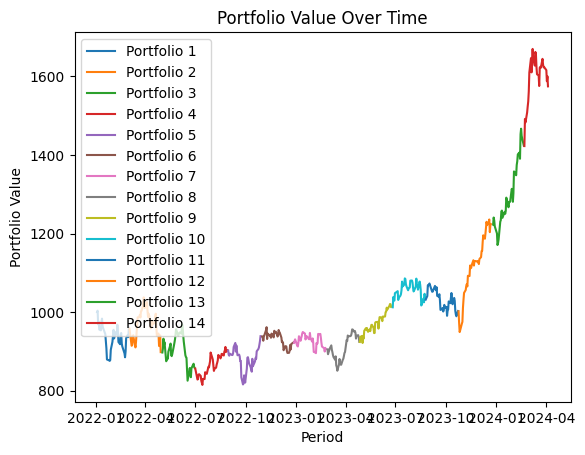

In [81]:
# Plot each array in bl_portfolio
for i, portfolio_values in enumerate(bl_portfolio):
    plt.plot(portfolio_values, label=f'Portfolio {i+1}')

plt.xlabel('Period')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

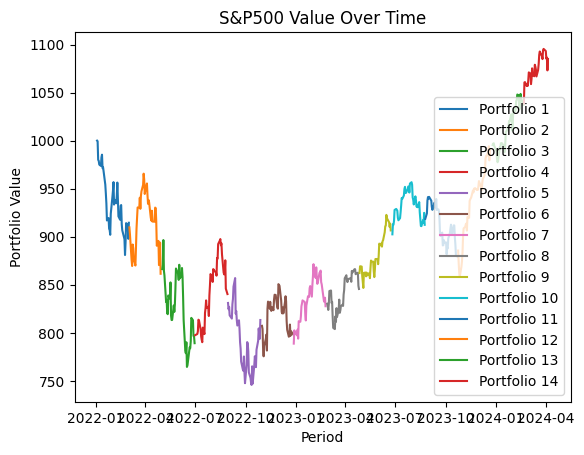

In [82]:
# Plot each array in bl_portfolio
for i, portfolio_values in enumerate(market):
    plt.plot(portfolio_values, label=f'Portfolio {i+1}')

plt.xlabel('Period')
plt.ylabel('Portfolio Value')
plt.title('S&P500 Value Over Time')
plt.legend()
plt.show()

In [83]:
#convert to a dataframe
df_portfolio=pd.DataFrame(bl_portfolio)
# Replace all the nan to value 0. When you do a dataframe it will create several row per each run and the columns are the dates
df_portfolio.fillna(0, inplace=True)
#transpose to have the date as row and all the run as columns
df_portfolio = df_portfolio.transpose()
#sum all the columns in the same row to have and unique value per row
df_portfolio = df_portfolio.sum(axis=1)

start= fecha
start_date = datetime.strptime(start, "%Y-%m-%d")
end_date = start_date + timedelta(days=leng_period*periods)
end = end_date.strftime("%Y-%m-%d")
sp500 = yf.download("^GSPC",start=start,end=end)['Adj Close']
market=sp500/sp500[0]*Total_invest_market

[*********************100%%**********************]  1 of 1 completed


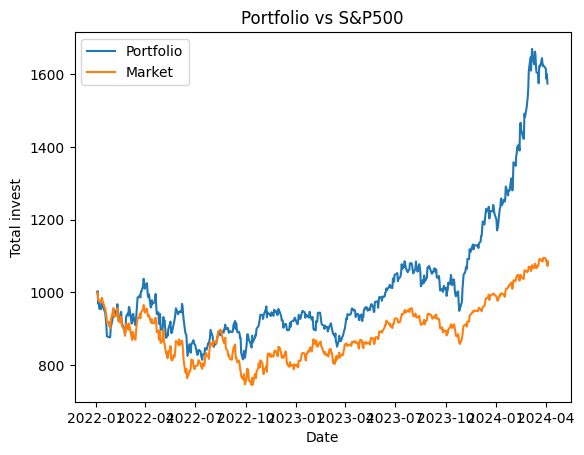

In [84]:
# Plot df_portfolio
plt.plot(df_portfolio.index, df_portfolio, label='Portfolio')
plt.xlabel('Date')
plt.ylabel('Total invest')
plt.title('Portfolio vs S&P500')

# Plot market
plt.plot(market.index, market, label='Market')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [85]:
df=pd.DataFrame(weights, columns=assets)

In [86]:
import plotly.express as px

# Assuming df is your DataFrame with data
fig = px.bar(df, barmode='stack')
fig.update_layout(
    title='Stacked Bar Chart',
    xaxis=dict(title='Category'),
    yaxis=dict(title='Values'),
    legend=dict(title='Assets'),
)
# Create dropdown menu for variable selection
buttons = [
    dict(label=var, method='update', args=[{'visible': [col == var for col in df.columns]}])
    for var in df.columns
]
# Add an option to reset the graph
buttons.append(
    dict(label="Reset", method="update", args=[{'visible': [True] * len(df.columns)}])
)

fig.update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            direction='down',
            showactive=True,
            x=0.1,
            xanchor='left',
            y=1.15,
            yanchor='top'
        ),
    ]
)
fig.show()

In [87]:
hapi

[1.95,
 1.05,
 1.5,
 0.8999999999999999,
 0.75,
 1.05,
 0.6,
 0.6,
 1.05,
 1.65,
 0.75,
 1.05,
 0.8999999999999999,
 0.6]

In [88]:
print('Total cost fee USD',sum(hapi))
print('% cost total investment', sum(hapi)/1_000 *100 )
print('Total % return', (df_portfolio[-1]-df_portfolio[0])/df_portfolio[0]*100)

Total cost fee USD 14.400000000000002
% cost total investment 1.4400000000000002
Total % return 57.46460197282606
